In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparando o ambiente

In [2]:
%env SM_FRAMEWORK=tf.keras
!pip install -U segmentation-models

env: SM_FRAMEWORK=tf.keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.6 MB/s 


# Classe de carregamento do Dataset

In [3]:
import numpy as np
def NDVI(r, n):
	np.seterr(divide='ignore', invalid='ignore') # Ignore the divided by zero or Nan appears
	ndvi = (n-r)/(n+r) # The NDVI formula
	ndvi = np.float32(ndvi) # Convert datatype to float32 for memory saving.

	return (ndvi)

In [4]:
import keras
import numpy as np
import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt
import tensorflow.keras

dataset_path = '/content/drive/MyDrive/ColabAux/walysson2107/AgriVis/dataset'
batch_size=32
img_size=256

class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=None,train_nir_path=None,train_mask_path=None, train_mask_paths=None, augmentations=None, 
                 batch_size=batch_size,img_size=img_size, n_channels=3, shuffle=True, preprocessing=None, is_nir=False, is_ndvi=False, is_sobel=False, is_bilateral=False):
        'Initialization'
        
        if train_mask_paths is None:
          self.train_mask_paths = glob.glob(train_mask_path+'/*')
        else:
          self.train_mask_paths = train_mask_paths

        self.preprocessing = preprocessing
        self.batch_size = batch_size
        self.train_im_path = train_im_path
        self.train_nir_path = train_nir_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.is_nir = is_nir
        self.is_ndvi = is_ndvi
        self.is_sobel = is_sobel
        self.is_bilateral = is_bilateral
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_mask_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_mask_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_mask_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,y #np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_mask_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size))

        # Generate data
        for i, mask_path in enumerate(list_IDs_im):
            mask = np.load(mask_path)

            im_path = mask_path.replace(self.train_mask_path, self.train_im_path)
            im_path = im_path.replace('npy', 'PNG')
            
            im = np.array(Image.open(im_path))
            if self.train_nir_path:
              im = cv2.resize(im,(self.img_size,self.img_size))
              im_nir_path = im_path.replace(self.train_im_path, self.train_nir_path)
              im_nir = np.array(Image.open(im_nir_path))
              
              if self.is_ndvi:
                #ndvi = (im_nir.astype(np.float32) - im[...,0].astype(np.float32))/(im_nir.astype(np.float32) + im[...,0].astype(np.float32) + 1e-6)
                #ndvi = np.divide(np.subtract(im_nir, im[...,0]), (np.add(im_nir, im[...,0])  + 1e-10))
                ndvi = NDVI(im[...,0], im_nir)
                ndvi = (ndvi + 1) * 127.5
              if self.is_sobel:
                sobelx = cv2.Sobel(im_nir, cv2.CV_64F, 1, 0, ksize=3)
                sobelx = (255*(sobelx - np.min(sobelx))/np.ptp(sobelx)).astype(int)
                sobely = cv2.Sobel(im_nir, cv2.CV_64F, 0, 1, ksize=3)
                sobely = (255*(sobely - np.min(sobely))/np.ptp(sobely)).astype(int)
              #im = np.dstack((im, ndvi))
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

            # Resize sample
            X[i,:,:,0:3] = im #cv2.resize(im,(self.img_size,self.img_size))
            if self.is_nir:
              X[i,:,:,3] = im_nir
              if self.is_ndvi:
                X[i,:,:,4] = ndvi
                if self.is_sobel:
                  X[i,:,:,5] = sobelx
                  X[i,:,:,6] = sobely
              elif self.is_sobel:
                X[i,:,:,4] = sobelx
                X[i,:,:,5] = sobely
            elif self.is_ndvi:
              X[i,:,:,3] = ndvi
              if self.is_sobel:
                X[i,:,:,4] = sobelx
                X[i,:,:,5] = sobely
            elif self.is_sobel:
                X[i,:,:,3] = sobelx
                X[i,:,:,4] = sobely
            
            if self.is_bilateral:
              for j in range(3,self.n_channels):
                X[i,:,:,j] = cv2.bilateralFilter(np.uint8(X[i,:,:,j]), 9, 25, 25)

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size)) #[..., np.newaxis]
            #y[y>0] = 255

        #y[y>0] = 255
        y = np.uint8(y)
        #y = np.array(y)/255
        X = np.uint8(X)
        y = tensorflow.keras.utils.to_categorical(y, num_classes=9, dtype="float32")
        if self.preprocessing:
          X = self.preprocessing(X)

        return X, y

# Teste DataGenerator

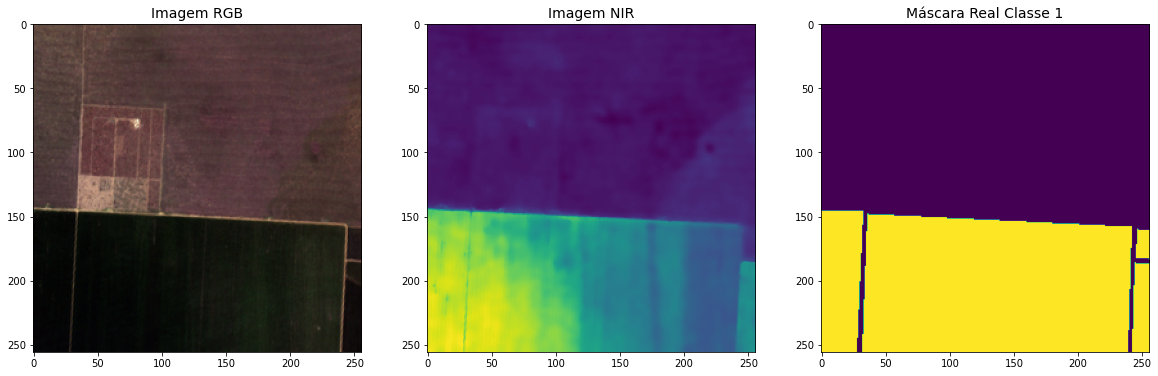

In [15]:
dataset_path = '/content/drive/MyDrive/ColabAux/walysson2107/AgriVis/dataset'

train_im_path = dataset_path+'/images/rgb' 
train_nir_path = dataset_path+'/images/nir' 
train_mask_path = dataset_path+'/masks/train'

test_generator = DataGenerator(train_im_path=train_im_path, train_nir_path=train_nir_path, train_mask_path=train_mask_path,
                              batch_size=1, img_size=256, n_channels=5, is_nir=True, is_ndvi=True, is_bilateral=True)

x_data, y_data = test_generator.__getitem__(0)

plt.figure(figsize=(20,9))
plt.subplot(131)
plt.title('Imagem RGB', fontdict={'fontsize': 14})
plt.imshow(x_data[0,:,:,0:3])

plt.subplot(132)
plt.title('Imagem NIR', fontdict={'fontsize': 14})
plt.imshow(x_data[0,:,:,3])

plt.subplot(133)
plt.title('Máscara Real Classe 1', fontdict={'fontsize': 14})
plt.imshow(y_data[0,:,:,1])


# Preparação dos dados

In [16]:
import pandas as pd
import segmentation_models as sm
from keras.callbacks import ModelCheckpoint
import random
from sklearn.model_selection import train_test_split

img_size= 256 #512
batch_size=8

classes = ['_background_', 'plant_madura', 'plant_jovem', 'preparo_plant', 
           'linha_div_plant','relva_floresta', 'solo', 'agua', 'habitacao']

dataset_path = '/content/drive/MyDrive/ColabAux/walysson2107/AgriVis/dataset'

train_im_path = dataset_path+'/images/rgb' 
train_nir_path = dataset_path+'/images/nir' 
train_mask_path = dataset_path+'/masks/train'
val_mask_path = dataset_path+'/masks/val'
test_mask_path = dataset_path+'/masks/test'


Segmentation Models: using `tf.keras` framework.


In [17]:
def join_classes_plant4(y_data):
  array_plant = np.empty((len(y_data),256,256,3), dtype="float32")
  array_plant[..., 0] = y_data[..., 0] + y_data[..., 5] +  y_data[..., 6] + y_data[..., 7] + y_data[..., 8] + y_data[..., 4]
  array_plant[..., 1] = y_data[..., 1] + y_data[..., 2]
  array_plant[..., 2] = y_data[..., 3]
  return array_plant

In [18]:
coresRGB_plant = [(252, 209, 99), #não plantação
                  (32, 116, 1), #plantação verde 
                  (153, 183, 24)] #area de preparo de plantação


def my_label_join(y, cores, img_size=256):
  label_join = []
  for y_i in y:
    blank_image = np.ones((img_size, img_size, 3), np.uint8) * 255
    for i in range(0, len(cores)):
      blank_image[y_i[:,:,i] > 0.5] = cores[i]
    label_join.append(blank_image)

  return label_join 

# Treinamento com a U-net

In [19]:
train_generator = DataGenerator(train_im_path=train_im_path, train_nir_path=train_nir_path, train_mask_path=train_mask_path,
                  batch_size=114, img_size=256, n_channels=4, is_nir=True)

x_train, y_train = train_generator.__getitem__(0)
y_train = join_classes_plant4(y_train)

val_generator = DataGenerator(train_im_path=train_im_path, train_nir_path=train_nir_path, train_mask_path=val_mask_path,
                  batch_size=37, img_size=256, n_channels=4, is_nir=True)

x_val, y_val = val_generator.__getitem__(0)
y_val = join_classes_plant4(y_val)

test_generator = DataGenerator(train_im_path=train_im_path, train_nir_path=train_nir_path, train_mask_path=test_mask_path,
                  batch_size=37, img_size=256, n_channels=4, is_nir=True)

x_test, y_test = test_generator.__getitem__(0)
y_test = join_classes_plant4(y_test)

In [20]:
import pandas as pd
import segmentation_models as sm
from keras.callbacks import ModelCheckpoint
import random

bb = 'efficientnetb7'
loss = sm.losses.JaccardLoss()
epochs = 280
img_size = 256

model = sm.Unet(bb, input_shape=(None, None, 4), encoder_weights=None, classes=3, activation='softmax')
model.compile(
    'Adam',
    loss=loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), 
             sm.metrics.IOUScore(threshold=0.5, class_weights=[2,0,0],name='iou_no_plant'),
             sm.metrics.IOUScore(threshold=0.5, class_weights=[0,2,0],name='iou_plant'),
             sm.metrics.IOUScore(threshold=0.5, class_weights=[0,0,2],name='iou_prep')],
)

history = model.fit(x_train, y_train, epochs=epochs, batch_size=8, validation_data=(x_val, y_val), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Epoch 1/280
15/15 [==============================] - 55s 889ms/step - loss: 0.7355 - iou_score: 0.2517 - iou_no_plant: 0.2021 - iou_plant: 0.1829 - iou_prep: 0.1183 - val_loss: 0.8740 - val_iou_score: 0.1316 - val_iou_no_plant: 0.2368 - val_iou_plant: 0.0242 - val_iou_prep: 0.0022
Epoch 2/280
15/15 [==============================] - 7s 490ms/step - loss: 0.5574 - iou_score: 0.5016 - iou_no_plant: 0.3123 - iou_plant: 0.2671 - iou_prep: 0.4237 - val_loss: 0.7781 - val_iou_score: 0.2373 - val_iou_no_plant: 0.2606 - val_iou_plant: 0.1396 - val_iou_prep: 0.0745
Epoch 3/280
15/15 [==============================] - 7s 490ms/step - loss: 0.4499 - iou_score: 0.5801 - iou_no_plant: 0.3612 - iou_plant: 0.3064 - iou_prep: 0.4926 - val_loss: 0.8322 - val_iou_score: 0.1719 - val_iou_no_plant: 0.2175 - val_iou_plant: 0.1038 - val_iou_prep: 0.0224
Epoch 4/280
15/15 [==============================] - 7s 493ms/step - loss: 0.4596 - iou_score: 0.5587 - iou_no_plant: 0.3622 - iou_plant: 0.2830 - iou_prep:

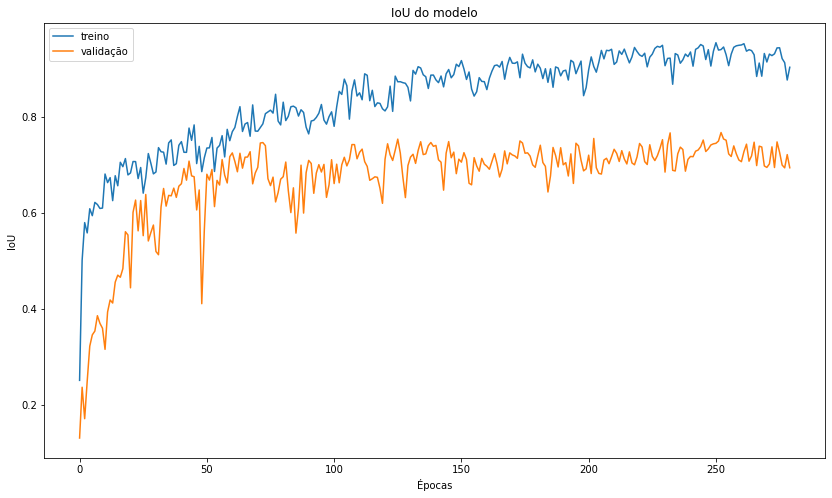

In [26]:
plt.figure(figsize=(14, 8))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('IoU do modelo')
plt.ylabel('IoU')
plt.xlabel('Épocas')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

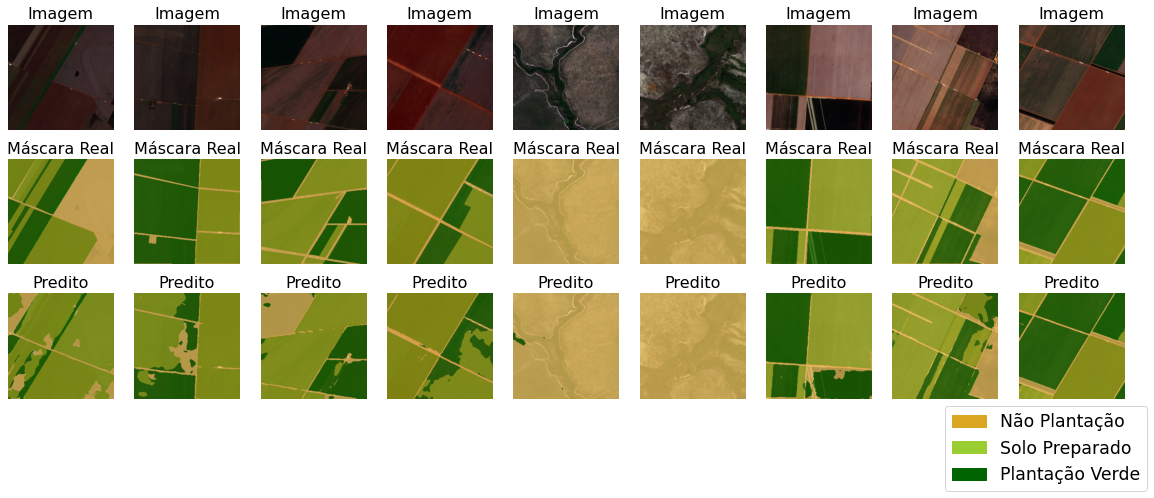

In [21]:
import matplotlib.patches as mpatches

y_pred = model.predict(x_val)
y_pred_join = my_label_join(y_pred, coresRGB_plant)
label_join = my_label_join(y_val, coresRGB_plant)

batch_size = 9

classes = ['Não Plantação', 'Solo Preparado', 'Plantação Verde']
cores = ['goldenrod', 'yellowgreen', 'darkgreen']

plt.figure(figsize=(20, 7))

for it in range(0, batch_size):
  plt.subplot(3, batch_size, 1+it)
  plt.imshow(x_val[it,:,:,0:3])
  plt.title('Imagem', fontdict={'fontsize': 16})
  plt.axis('off')

for it in range(0, batch_size):
  plt.subplot(3, batch_size, (batch_size + 1)+it)
  plt.imshow(x_val[it,:,:,0:3])
  plt.imshow(label_join[it], alpha=0.7)
  plt.title('Máscara Real', fontdict={'fontsize': 16})
  plt.axis('off')

for it in range(0, batch_size):
  plt.subplot(3, batch_size, (2*batch_size + 1)+it)
  plt.imshow(x_val[it,:,:,0:3])
  plt.imshow(y_pred_join[it], alpha=0.7)
  plt.title('Predito', fontdict={'fontsize': 16})
  plt.axis('off')

patches = [mpatches.Patch(color=cores[i], label=classes[i]) for i in range(len(classes))]
plt.legend(handles=patches, bbox_to_anchor=(-0.72, 1, 0.5, -1.05), loc=2, borderaxespad=0.1, fontsize='xx-large')